# Import important libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Dropout, BatchNormalization, Flatten, Input, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16, MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.models import Sequential

### Directory Structure:
```
dataset/
├── train/
│   ├── Class1/
│   ├── Class2/
│   ├── Class3/
│   └── (other classes...)
├── val/
│   ├── Class1/
│   ├── Class2/
│   ├── Class3/
│   └── (other classes...)
└── test/
    ├── Class1/
    ├── Class2/
    ├── Class3/
    └── (other classes...)
```
Each subdirectory under train and val should contain images of the respective fruit category.

# Setup Data Input

In [2]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

In [3]:
train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/fruits/fruits-360-original-size/Training',
    shuffle=True,
    batch_size=16,
    target_size=(64, 64),
    class_mode='categorical',
)
val_generator = val_datagen.flow_from_directory(
    '/kaggle/input/fruits/fruits-360-original-size/Validation',
    shuffle=False,
    target_size=(64, 64),
    batch_size=16,
    class_mode='categorical',
)
test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/fruits/fruits-360-original-size/Test',
    shuffle=False,
    target_size=(64, 64),
    batch_size=16,
    class_mode='categorical',
)

Found 6231 images belonging to 24 classes.
Found 3114 images belonging to 24 classes.
Found 3110 images belonging to 24 classes.


# Model preparation

In [4]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(rate=0.3),
    Dense(train_generator.num_classes, activation='softmax')
])
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


# Train model with pre-trained feature extraction

In [5]:
from tensorflow.keras.mixed_precision import set_global_policy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=1e-6,
    verbose=1,
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
)

set_global_policy('float32')

steps_per_epoch = 50
validation_steps = 25

history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[lr_scheduler, early_stopping],
)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 33s 594ms/step - accuracy: 0.1422 - loss: 3.2098 - val_accuracy: 0.4750 - val_loss: 2.3658 - learning_rate: 0.0010
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 29s 577ms/step - accuracy: 0.4679 - loss: 1.8102 - val_accuracy: 0.6025 - val_loss: 1.9327 - learning_rate: 0.0010
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 29s 579ms/step - accuracy: 0.5823 - loss: 1.3321 - val_accuracy: 0.3050 - val_loss: 2.1350 - learning_rate: 0.0010
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 29s 578ms/step - accuracy: 0.6508 - loss: 1.1221 - val_accuracy: 0.5050 - val_loss: 1.5300 - learning_rate: 0.0010
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 29s 576ms/step - accuracy: 0.7180 - loss: 0.8977 - val_accuracy: 0.4000 - val_loss: 1.8336 - learning_rate: 0.0010


# Fine-tune model by unfreezing some top layers of feature extractions

In [6]:
for layer in base_model.layers[-5:]:
    layer.trainable = True

for layer in base_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
history_fine = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 40s 747ms/step - accuracy: 0.7591 - loss: 0.8996 - val_accuracy: 0.6500 - val_loss: 1.3427 - learning_rate: 1.0000e-05
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 36s 728ms/step - accuracy: 0.8061 - loss: 0.6925 - val_accuracy: 0.6525 - val_loss: 1.0456 - learning_rate: 1.0000e-05
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 736ms/step - accuracy: 0.7703 - loss: 0.7005 - val_accuracy: 0.5900 - val_loss: 0.9715 - learning_rate: 1.0000e-05
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 738ms/step - accuracy: 0.8155 - loss: 0.6411 - val_accuracy: 0.8725 - val_loss: 0.5055 - learning_rate: 1.0000e-05
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 735ms/step - accuracy: 0.8485 - loss: 0.5168 - val_accuracy: 0.6650 - val_loss: 1.1149 - learning_rate: 1.0000e-05


# Evaluate model

In [7]:
loss, acc = model.evaluate(test_generator, steps=50)
print(f"Loss: {loss:.2f}\nAccuracy: {acc:.2f}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 387ms/step - accuracy: 0.7754 - loss: 0.6677
Loss: 0.62
Accuracy: 0.84


# Plotting training process

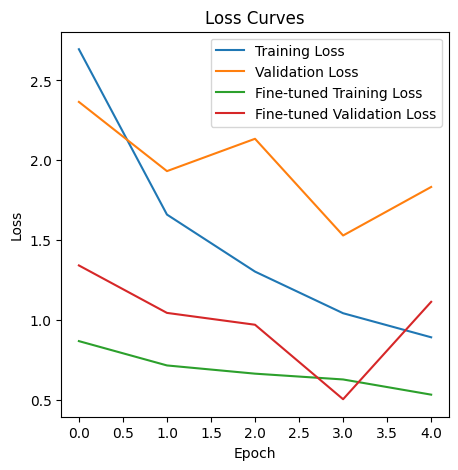

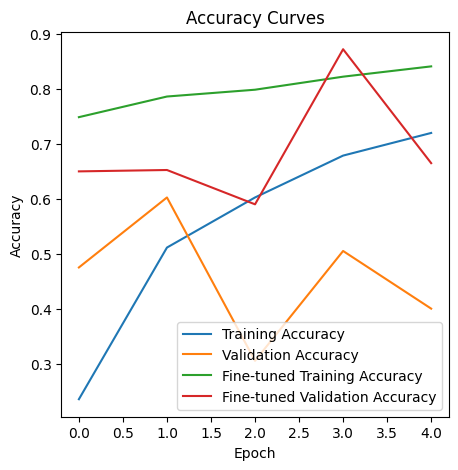

In [8]:
plt.figure(figsize=(5, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history_fine.history['loss'], label='Fine-tuned Training Loss')
plt.plot(history_fine.history['val_loss'], label='Fine-tuned Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.show()

plt.figure(figsize=(5, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_fine.history['accuracy'], label='Fine-tuned Training Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Fine-tuned Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()
plt.show()

# Visualize some results

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


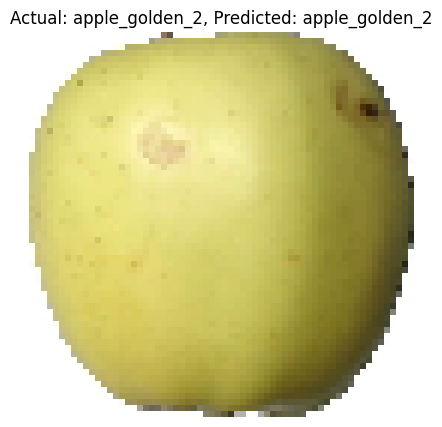

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


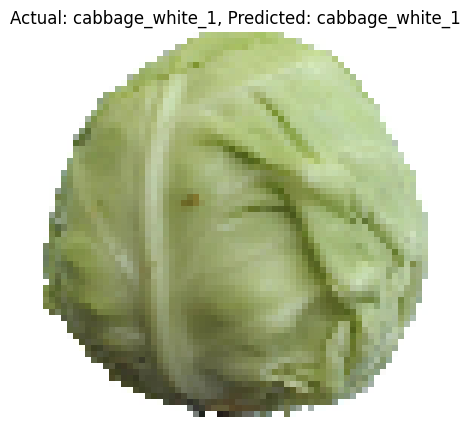

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


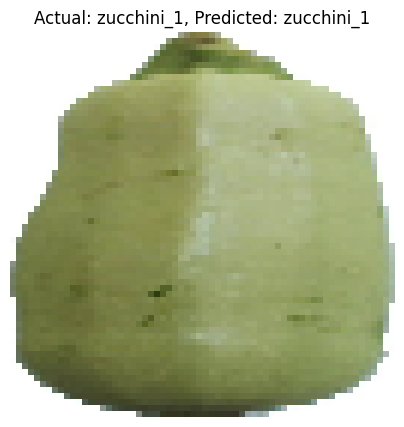

In [9]:
import os
import sys
from collections import Counter

actual_count = Counter()
predicted_count = Counter()

def get_class_name_from_index(predicted_index, class_index_mapping):
    for class_name, index in class_index_mapping.items():
        if index == predicted_index:
            return class_name
    return "Unknown"

def visualize_prediction_with_actual(img_path, class_index_mapping):
    class_name = os.path.basename(os.path.dirname(img_path))

    img = load_img(img_path, target_size=(64, 64))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_index = np.argmax(prediction, axis=-1)[0]
    predicted_class_name = get_class_name_from_index(predicted_index, class_index_mapping)

    actual_count[class_name] += 1
    predicted_count[class_name] += 1

    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.title(f"Actual: {class_name}, Predicted: {predicted_class_name}")
    plt.axis('off')
    plt.show()

class_index_mapping = train_generator.class_indices

sample_images = [
    '/kaggle/input/fruits/fruits-360-original-size/Test/apple_golden_2/r0_119.jpg',
    '/kaggle/input/fruits/fruits-360-original-size/Test/cabbage_white_1/r0_175.jpg',
    '/kaggle/input/fruits/fruits-360-original-size/Test/zucchini_1/r0_19.jpg'
]

for img_path in sample_images:
    visualize_prediction_with_actual(img_path, class_index_mapping)